In [1]:
import numpy as np 
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
quandl.ApiConfig.api_key = "y8s4u9YiKARZizCY5xWR"


In [72]:
# Getting data 
data = quandl.get_table('SHARADAR/SF1', ticker='ALXN')


In [73]:
# Process data #liabilities
Matrix = data[['eps', 'dps', 'roe', 'liabilities', 'price']] 
for i in ['eps', 'dps', 'roe', 'liabilities', 'price']:
    Matrix.fillna(Matrix[i].mean(), inplace = True)

C:\Users\Boon Yang\Anaconda3\lib\site-packages\pandas\core\frame.py:3787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [74]:
# normalise data
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['eps'] = min_max_scaler.fit_transform(df.eps.values.reshape(-1,1))
    df['dps'] = min_max_scaler.fit_transform(df.dps.values.reshape(-1,1))
    df['liabilities'] = min_max_scaler.fit_transform(df.liabilities.values.reshape(-1,1))
    df['roe'] = min_max_scaler.fit_transform(df.roe.values.reshape(-1,1))
    df['price'] = min_max_scaler.fit_transform(df['price'].values.reshape(-1,1))
    return df
data2 = normalize_data(Matrix)
data2.head()

C:\Users\Boon Yang\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Boon Yang\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Boon Yang\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pa

,eps,dps,roe,liabilities,price
None,,,,,
0,0.750466,0.0,0.800519,0.957155,0.601540
1,0.713222,0.0,0.799870,0.930482,0.615666
2,0.508380,0.0,0.790788,0.987318,0.965759
3,1.000000,0.0,0.855336,0.183657,0.936482
4,0.621974,0.0,0.820629,0.190937,0.669582


In [6]:
#Split data into training set and test(validation set)
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


In [7]:
# importing depedndancies for the model 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model


C:\Users\Boon Yang\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
import math,time

In [9]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model


In [75]:
window = 15
X_train, y_train, X_test, y_test = load_data(data2, window)
print (X_train[0], y_train[0])

[[0.75046555 0.         0.80051898 0.95715515 0.60153959]
 [0.7132216  0.         0.79987026 0.93048248 0.61566612]
 [0.50837989 0.         0.79078819 0.98731752 0.96575851]
 [1.         0.         0.85533571 0.18365657 0.93648178]
 [0.62197393 0.         0.82062926 0.19093656 0.6695824 ]
 [0.63128492 0.         0.83295491 0.1311614  0.46923128]
 [0.56052142 0.         0.84041518 0.0531125  0.35540007]
 [0.48230912 0.         0.82354849 0.03108091 0.19558085]
 [0.70391061 0.         1.         0.02000859 0.11437887]
 [0.42178771 0.         0.8498216  0.04704962 0.08205674]
 [0.26350093 0.         0.48459293 0.04750899 0.08545018]
 [0.18901304 0.         0.04508596 0.04262322 0.04112562]
 [0.20018622 0.         0.4904314  0.03682564 0.02276112]
 [0.22197393 0.         0.61076873 0.03000992 0.0098118 ]
 [0.16573557 0.         0.60428154 0.02998707 0.01094806]] 0.009284613849122462


C:\Users\Boon Yang\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [11]:
model = build_model([5,window,1])

Compilation Time :  0.06821393966674805


In [ ]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 285 samples, validate on 32 samples
Epoch 1/90
285/285 [==============================] - 2s 7ms/step - loss: 0.1629 - acc: 0.0070 - val_loss: 0.0927 - val_acc: 0.0000e+00
Epoch 2/90
285/285 [==============================] - 2s 5ms/step - loss: 0.0970 - acc: 0.0070 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 3/90
285/285 [==============================] - 2s 6ms/step - loss: 0.0886 - acc: 0.0070 - val_loss: 0.0783 - val_acc: 0.0000e+00
Epoch 4/90
285/285 [==============================] - 2s 7ms/step - loss: 0.0901 - acc: 0.0070 - val_loss: 0.0874 - val_acc: 0.0000e+00
Epoch 5/90
285/285 [==============================] - 2s 5ms/step - loss: 0.0811 - acc: 0.0070 - val_loss: 0.0799 - val_acc: 0.0000e+00
Epoch 6/90
285/285 [==============================] - 1s 5ms/step - loss: 0.0747 - acc: 0.0070 - val_loss: 0.0708 - val_acc: 0.0000e+00
Epoch 7/90
285/285 [==============================] - 1s 5ms/step - loss: 0.0649 - acc: 0.0070 - val_loss: 0.0594 - val_acc: 0.0000e+00
Epo

Epoch 61/90
285/285 [==============================] - 2s 7ms/step - loss: 0.0118 - acc: 0.0140 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 62/90
285/285 [==============================] - 2s 6ms/step - loss: 0.0110 - acc: 0.0140 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 63/90
285/285 [==============================] - 2s 6ms/step - loss: 0.0108 - acc: 0.0140 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 64/90
285/285 [==============================] - 2s 6ms/step - loss: 0.0108 - acc: 0.0140 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 65/90
285/285 [==============================] - 2s 7ms/step - loss: 0.0114 - acc: 0.0140 - val_loss: 0.0024 - val_acc: 0.0000e+00
Epoch 66/90
285/285 [==============================] - 2s 7ms/step - loss: 0.0110 - acc: 0.0140 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 67/90
285/285 [==============================] - 2s 6ms/step - loss: 0.0104 - acc: 0.0140 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 68/90
285/285 [====================

In [70]:
y_pred = model.predict(X_test)

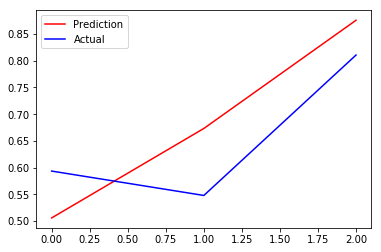

In [71]:
import matplotlib.pyplot as plt2

plt2.plot(y_pred,color='red', label='Prediction')
plt2.plot(y_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

